=== Time-Domain Results ===
Average External Power  :  0.120156 W
Average Damping Power   : -0.120380 W
Average Spring Power    : -0.000192 W
Net Power (should be ~0): -4.165e-04 W
Steady-state |x1| amplitude:  0.419936 m
Steady-state |x2| amplitude:  0.163023 m


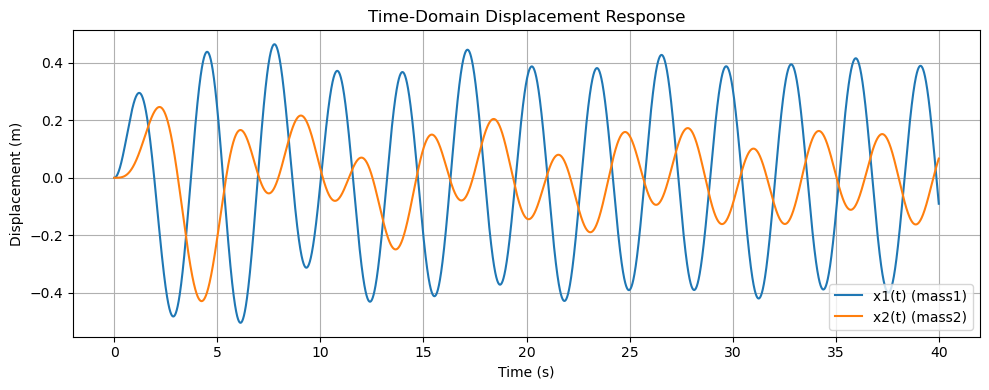

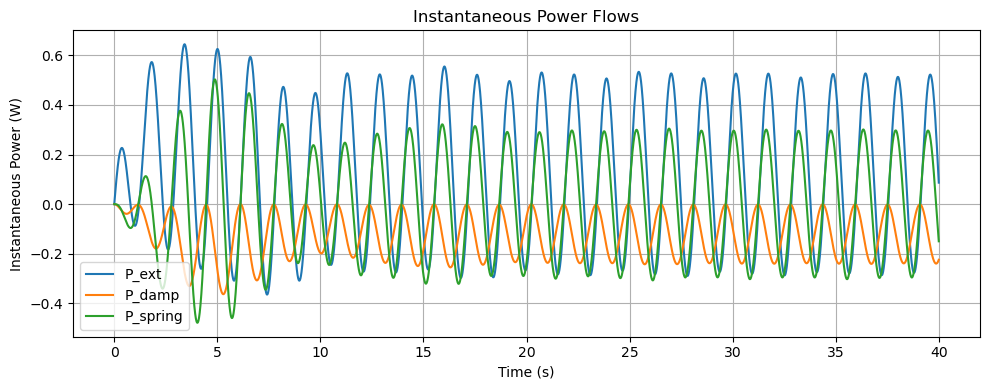


=== Frequency-Domain (Phasor) Results ===
Effective Dynamic Stiffness Kd_eff: (-2.3799126637554586+0.7493449781659389j)
Displacement phasor X1: (-0.382284447686653-0.12036699306977919j)  (|X1| = 0.400786 m)
Displacement phasor X2: (0.09750007014393536+0.10409360006733817j)  (|X2| = 0.142624 m)
Velocity phasor V1: (0.24073398613955838-0.764568895373306j)
Complex Power S: (0.12036699306977919+0.382284447686653j)
Active Power (P): 0.120367 W
Reactive Power (Q): 0.382284 var


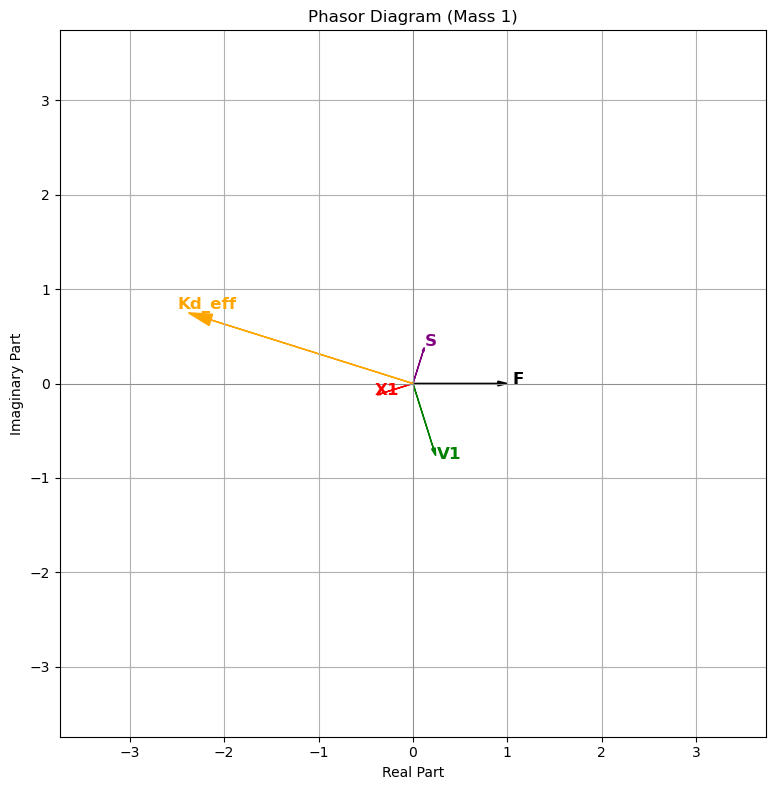

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ==============================
# 1. System Parameters
# ==============================
# Mass-spring-damper parameters for mass1 (attached to ground and driven)
m1 = 1.0       # mass1 (kg)
c1 = 0.2       # damper on mass1 (N·s/m)
k1 = 1.0       # spring constant on mass1 (N/m)

# Parameters for mass2 (attached to mass1 via second spring-damper)
m2 = 0.5       # mass2 (kg)
c2 = 0.1       # damper between mass1 and mass2 (N·s/m)
k2 = 0.5       # spring constant between mass1 and mass2 (N/m)

# Driving force parameters (applied to mass1)
F0 = 1.0       # force amplitude (N)
omega = 2.0    # driving angular frequency (rad/s)

# ==============================
# 2. Time-Domain Analysis
# ==============================
# State vector: z = [x1, v1, x2, v2]
def ode_system(z, t):
    x1, v1, x2, v2 = z
    # Equation for mass1:
    # m1*x1'' + c1*x1' + k1*x1 + c2*(x1' - x2') + k2*(x1-x2) = F0*cos(omega*t)
    a1 = (F0*np.cos(omega*t) - c1*v1 - k1*x1 - c2*(v1 - v2) - k2*(x1 - x2)) / m1
    # Equation for mass2:
    # m2*x2'' + c2*(x2' - x1') + k2*(x2-x1) = 0
    a2 = (- c2*(v2 - v1) - k2*(x2 - x1)) / m2
    return [v1, a1, v2, a2]

# Time vector for simulation
t_max = 40.0
num_points = 8001
t = np.linspace(0, t_max, num_points)

# Initial conditions: both masses start at rest at zero displacement
z0 = [0.0, 0.0, 0.0, 0.0]
sol = odeint(ode_system, z0, t)
x1 = sol[:, 0]
v1 = sol[:, 1]
x2 = sol[:, 2]
v2 = sol[:, 3]

# Instantaneous power calculations:
# External power delivered to mass1:
P_ext = F0 * np.cos(omega*t) * v1

# Power dissipated in damper on mass1:
P_damp1 = -c1 * v1**2
# Power dissipated in damper between mass1 and mass2:
P_damp2 = -c2 * (v1 - v2)**2
P_damp = P_damp1 + P_damp2

# Power in the springs (energy storage, ideally averages to zero)
P_spring1 = -k1 * x1 * v1
P_spring2 = -k2 * (x1 - x2) * (v1 - v2)
P_spring = P_spring1 + P_spring2

# Average powers over a window spanning an integer number of periods
T = 2 * np.pi / omega  # Driving period
N_cycles = 3
t_start = 30.0
t_end = t_start + N_cycles * T
mask = (t >= t_start) & (t <= t_end)
t_steady = t[mask]
P_ext_avg   = np.trapz(P_ext[mask], t_steady) / (t_steady[-1] - t_steady[0])
P_damp_avg  = np.trapz(P_damp[mask], t_steady) / (t_steady[-1] - t_steady[0])
P_spring_avg= np.trapz(P_spring[mask], t_steady) / (t_steady[-1] - t_steady[0])

print("=== Time-Domain Results ===")
print(f"Average External Power  : {P_ext_avg: .6f} W")
print(f"Average Damping Power   : {P_damp_avg: .6f} W")
print(f"Average Spring Power    : {P_spring_avg: .6f} W")
print(f"Net Power (should be ~0): {P_ext_avg+P_damp_avg+P_spring_avg: .3e} W")
print(f"Steady-state |x1| amplitude: {np.max(np.abs(x1[mask])): .6f} m")
print(f"Steady-state |x2| amplitude: {np.max(np.abs(x2[mask])): .6f} m")

# Plot time-domain responses
plt.figure(figsize=(10,4))
plt.plot(t, x1, label="x1(t) (mass1)")
plt.plot(t, x2, label="x2(t) (mass2)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Time-Domain Displacement Response")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, P_ext, label="P_ext")
plt.plot(t, P_damp, label="P_damp")
plt.plot(t, P_spring, label="P_spring")
plt.xlabel("Time (s)")
plt.ylabel("Instantaneous Power (W)")
plt.title("Instantaneous Power Flows")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 3. Frequency-Domain (Phasor) Analysis
# ==============================
# For a 2-DOF system, we form the effective dynamic stiffness seen by mass1.
# Let Z2 = -m2*omega^2 + k2 + j*omega*c2 for the second mass branch.
Z2 = -m2*omega**2 + k2 + 1j*omega*c2

# Then, from the second equation, X2 = (k2 + 1j*omega*c2)/Z2 * X1.
# Substitute into the first equation yields the effective dynamic stiffness:
Kd_eff = (-m1*omega**2 + k1 + k2 + 1j*omega*(c1+c2)) - ((k2+1j*omega*c2)**2)/Z2

# Displacement phasor for mass1:
X1_phasor = F0 / Kd_eff
# Displacement phasor for mass2:
X2_phasor = (k2+1j*omega*c2)/Z2 * X1_phasor

# Velocity phasors:
V1_phasor = 1j * omega * X1_phasor
V2_phasor = 1j * omega * X2_phasor

# Complex power delivered to mass1:
S_complex = 0.5 * F0 * np.conjugate(V1_phasor)
P_active = S_complex.real  # Active power (dissipated in dampers)
Q_reactive = S_complex.imag

print("\n=== Frequency-Domain (Phasor) Results ===")
print(f"Effective Dynamic Stiffness Kd_eff: {Kd_eff}")
print(f"Displacement phasor X1: {X1_phasor}  (|X1| = {np.abs(X1_phasor):.6f} m)")
print(f"Displacement phasor X2: {X2_phasor}  (|X2| = {np.abs(X2_phasor):.6f} m)")
print(f"Velocity phasor V1: {V1_phasor}")
print(f"Complex Power S: {S_complex}")
print(f"Active Power (P): {P_active:.6f} W")
print(f"Reactive Power (Q): {Q_reactive:.6f} var")

# ==============================
# 4. Visualization: Phasor Diagram for Mass1
# ==============================
plt.figure(figsize=(8,8))
ax = plt.gca()
def draw_arrow(z, label, color):
    plt.arrow(0, 0, z.real, z.imag,
              head_width=0.05*np.abs(z),
              head_length=0.1*np.abs(z),
              fc=color, ec=color, length_includes_head=True)
    plt.text(z.real*1.05, z.imag*1.05, label, color=color, fontsize=12, fontweight='bold')

# Force phasor (assumed real and applied to mass1)
F_phasor = F0 + 0j
draw_arrow(F_phasor, "F", "black")
draw_arrow(X1_phasor, "X1", "red")
draw_arrow(V1_phasor, "V1", "green")
draw_arrow(S_complex, "S", "purple")
draw_arrow(Kd_eff, "Kd_eff", "orange")

all_phasors = [F_phasor, X1_phasor, V1_phasor, S_complex, Kd_eff]
max_val = max(np.abs(z) for z in all_phasors) * 1.5
plt.xlim(-max_val, max_val)
plt.ylim(-max_val, max_val)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Phasor Diagram (Mass 1)")
plt.grid(True)
plt.axhline(0, color="grey", lw=0.5)
plt.axvline(0, color="grey", lw=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

# ==============================
# 5. Discussion
# ==============================
#
# In this two-mass system, the time-domain simulation shows the transient and steady-state
# displacements for both masses as well as the instantaneous power flows. The external force
# input to mass1 is balanced, in steady state, by the energy dissipated in both dampers.
#
# In the frequency domain, by forming an effective dynamic stiffness for mass1 that accounts for
# the coupling with mass2, we obtain phasor quantities (X1, V1, etc.) that yield a complex power S.
# The real part of S gives the active (dissipated) power – which, in steady state, must match the
# average power dissipated by the dampers seen in the time-domain simulation.
#
# By comparing the displacement amplitudes and active power from both approaches, you can assess
# whether the energy fed into the system is in balance with the dissipation. Overdriving (too much
# power) would result in higher amplitudes (and potentially damaging vibrations), while underdriving
# would lead to decaying or insufficient oscillations.


=== Time-Domain Results ===
Average External Power  :  0.120156 W
Average Damping Power   : -0.120380 W
Average Spring Power    : -0.000192 W
Net Power (should be ~0): -4.165e-04 W
Steady-state |x1| amplitude:  0.419936 m
Steady-state |x2| amplitude:  0.163023 m


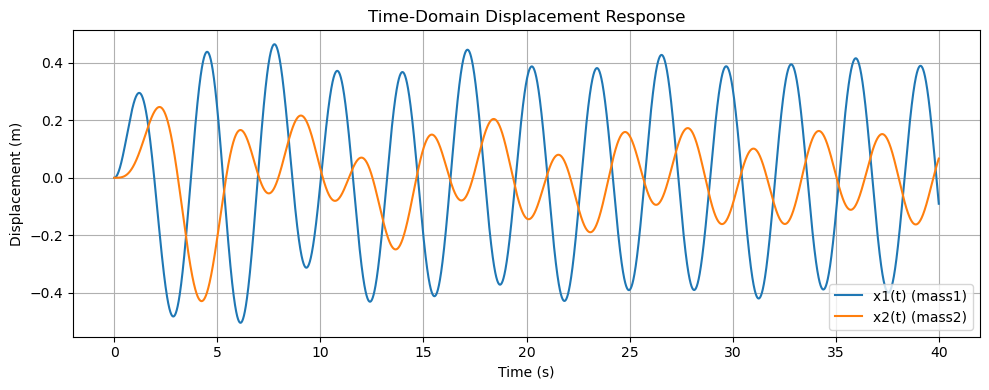

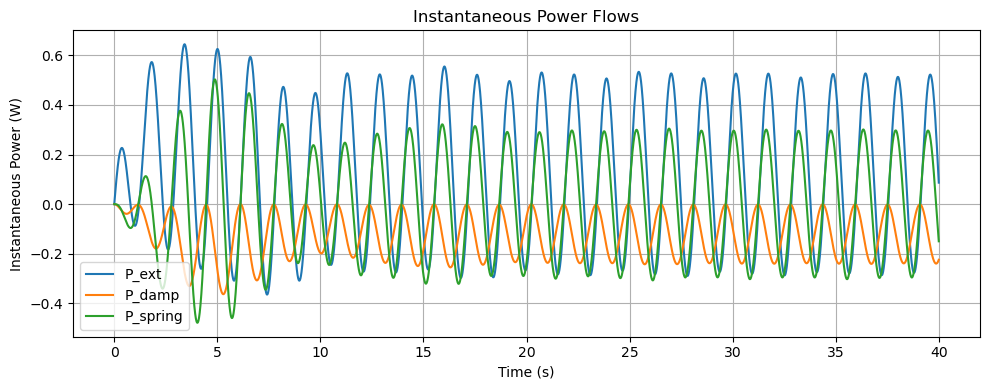


=== Frequency-Domain (Phasor) Results ===
Effective Dynamic Stiffness Kd_eff: (-2.3799126637554586+0.7493449781659389j)
Mass1: Displacement phasor X1: (-0.382284447686653-0.12036699306977919j)  (|X1| = 0.400786 m)
Mass1: Velocity phasor V1:     (0.24073398613955838-0.764568895373306j)
Mass1: Complex Power S:        (0.12036699306977919+0.382284447686653j)
Mass1: Active Power (P):       0.120367 W
Mass1: Reactive Power (Q):     0.382284 var
Mass2: Displacement phasor X2: (0.09750007014393536+0.10409360006733817j)  (|X2| = 0.142624 m)
Mass2: Velocity phasor V2:     (-0.20818720013467634+0.19500014028787072j)


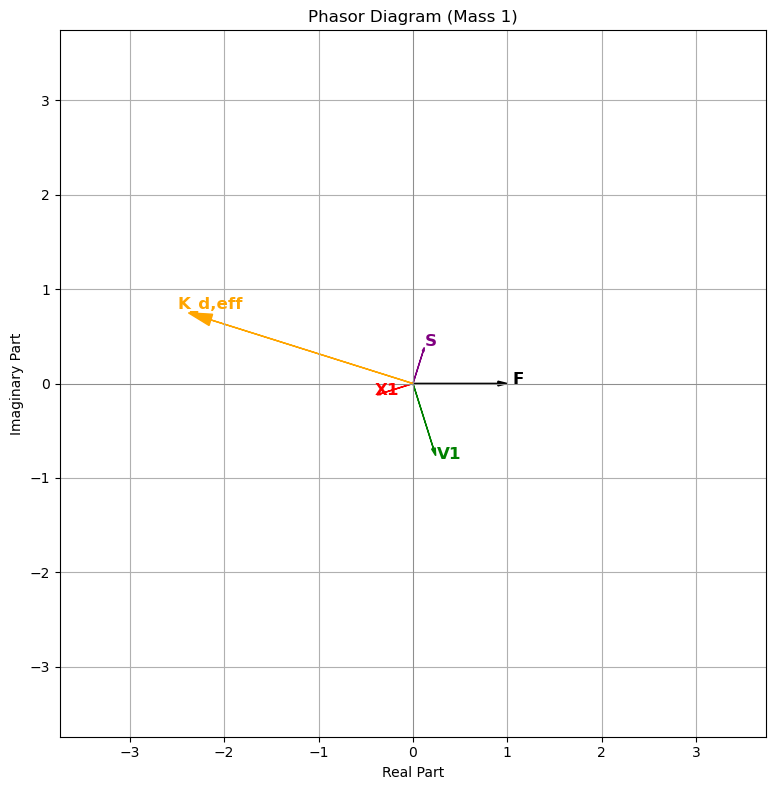

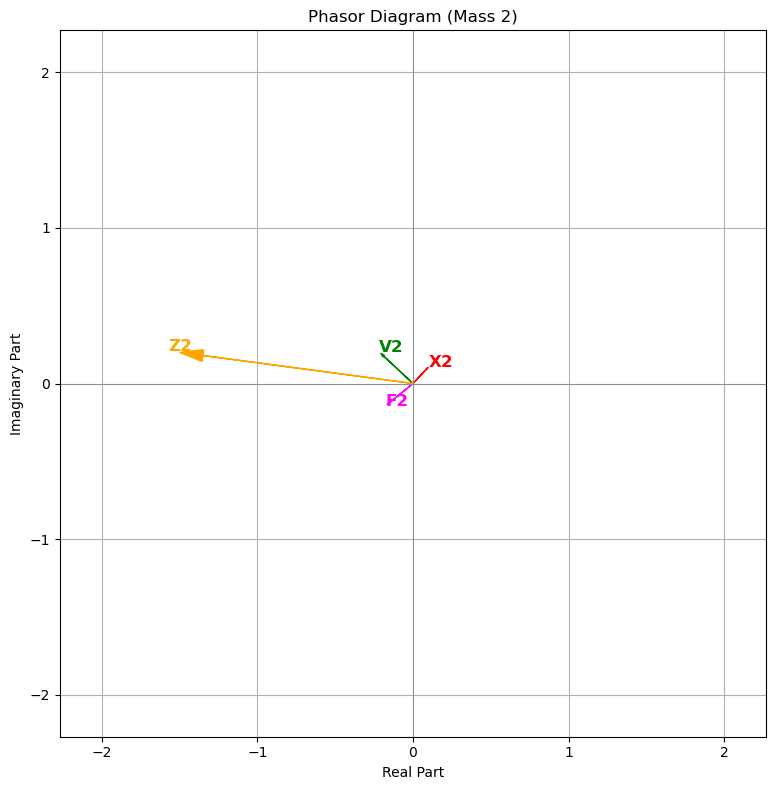

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ==============================
# 1. System Parameters
# ==============================
# Mass1 parameters (attached to ground and driven)
m1 = 1.0       # mass1 (kg)
c1 = 0.2       # damping on mass1 (N·s/m)
k1 = 1.0       # stiffness on mass1 (N/m)

# Mass2 parameters (coupled to mass1)
m2 = 0.5       # mass2 (kg)
c2 = 0.1       # damping between masses (N·s/m)
k2 = 0.5       # stiffness between masses (N/m)

# Driving force (applied to mass1)
F0 = 1.0       # force amplitude (N)
omega = 2.0    # driving angular frequency (rad/s)

# ==============================
# 2. Time-Domain Analysis
# ==============================
def ode_system(z, t):
    # z = [x1, v1, x2, v2]
    x1, v1, x2, v2 = z
    # Equation for mass1:
    a1 = (F0*np.cos(omega*t) - c1*v1 - k1*x1 - c2*(v1 - v2) - k2*(x1 - x2)) / m1
    # Equation for mass2:
    a2 = (- c2*(v2 - v1) - k2*(x2 - x1)) / m2
    return [v1, a1, v2, a2]

t_max = 40.0
num_points = 8001
t = np.linspace(0, t_max, num_points)
z0 = [0.0, 0.0, 0.0, 0.0]
sol = odeint(ode_system, z0, t)
x1 = sol[:,0]
v1 = sol[:,1]
x2 = sol[:,2]
v2 = sol[:,3]

# Instantaneous power computations:
P_ext = F0 * np.cos(omega*t) * v1  # External power to mass1
P_damp1 = -c1 * v1**2              # Damping power at mass1
P_damp2 = -c2 * (v1 - v2)**2         # Damping power between masses
P_damp = P_damp1 + P_damp2
P_spring1 = -k1 * x1 * v1
P_spring2 = -k2 * (x1 - x2) * (v1 - v2)
P_spring = P_spring1 + P_spring2

# Average over a steady-state window spanning an integer number of periods:
T = 2*np.pi/omega
N_cycles = 3
t_start = 30.0
t_end = t_start + N_cycles*T
mask = (t >= t_start) & (t <= t_end)
t_steady = t[mask]
P_ext_avg   = np.trapz(P_ext[mask], t_steady) / (t_steady[-1]-t_steady[0])
P_damp_avg  = np.trapz(P_damp[mask], t_steady) / (t_steady[-1]-t_steady[0])
P_spring_avg= np.trapz(P_spring[mask], t_steady) / (t_steady[-1]-t_steady[0])

print("=== Time-Domain Results ===")
print(f"Average External Power  : {P_ext_avg: .6f} W")
print(f"Average Damping Power   : {P_damp_avg: .6f} W")
print(f"Average Spring Power    : {P_spring_avg: .6f} W")
print(f"Net Power (should be ~0): {P_ext_avg+P_damp_avg+P_spring_avg: .3e} W")
print(f"Steady-state |x1| amplitude: {np.max(np.abs(x1[mask])): .6f} m")
print(f"Steady-state |x2| amplitude: {np.max(np.abs(x2[mask])): .6f} m")

# Plot time-domain displacements
plt.figure(figsize=(10,4))
plt.plot(t, x1, label="x1(t) (mass1)")
plt.plot(t, x2, label="x2(t) (mass2)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Time-Domain Displacement Response")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, P_ext, label="P_ext")
plt.plot(t, P_damp, label="P_damp")
plt.plot(t, P_spring, label="P_spring")
plt.xlabel("Time (s)")
plt.ylabel("Instantaneous Power (W)")
plt.title("Instantaneous Power Flows")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 3. Frequency-Domain (Phasor) Analysis
# ==============================
# For the two-mass system, we first compute the effective dynamic stiffness seen by mass1.
Z2 = -m2*omega**2 + k2 + 1j*omega*c2  # Dynamic stiffness for mass2 branch
# From the second equation: X2 = (k2+1j*omega*c2)/Z2 * X1.
# Effective dynamic stiffness for mass1:
Kd_eff = (-m1*omega**2 + k1 + k2 + 1j*omega*(c1+c2)) - ((k2+1j*omega*c2)**2)/Z2

X1_phasor = F0 / Kd_eff
V1_phasor = 1j * omega * X1_phasor
S_complex = 0.5 * F0 * np.conjugate(V1_phasor)
P_active = S_complex.real
Q_reactive = S_complex.imag

# For mass2:
X2_phasor = (k2+1j*omega*c2)/Z2 * X1_phasor
V2_phasor = 1j * omega * X2_phasor
# The force on mass2 via its branch is:
F2_phasor = Z2 * X2_phasor

print("\n=== Frequency-Domain (Phasor) Results ===")
print(f"Effective Dynamic Stiffness Kd_eff: {Kd_eff}")
print(f"Mass1: Displacement phasor X1: {X1_phasor}  (|X1| = {np.abs(X1_phasor):.6f} m)")
print(f"Mass1: Velocity phasor V1:     {V1_phasor}")
print(f"Mass1: Complex Power S:        {S_complex}")
print(f"Mass1: Active Power (P):       {P_active:.6f} W")
print(f"Mass1: Reactive Power (Q):     {Q_reactive:.6f} var")
print(f"Mass2: Displacement phasor X2: {X2_phasor}  (|X2| = {np.abs(X2_phasor):.6f} m)")
print(f"Mass2: Velocity phasor V2:     {V2_phasor}")

# ==============================
# 4. Visualization: Phasor Diagrams
# ==============================

def draw_arrow(z, label, color):
    plt.arrow(0, 0, z.real, z.imag,
              head_width=0.05*np.abs(z),
              head_length=0.1*np.abs(z),
              fc=color, ec=color, length_includes_head=True)
    plt.text(z.real*1.05, z.imag*1.05, label, color=color,
             fontsize=12, fontweight='bold')

# 4a. Phasor Diagram for Mass1
plt.figure(figsize=(8,8))
F1_phasor = F0 + 0j  # External force (applied to mass1)
draw_arrow(F1_phasor, "F", "black")
draw_arrow(X1_phasor, "X1", "red")
draw_arrow(V1_phasor, "V1", "green")
draw_arrow(S_complex, "S", "purple")
draw_arrow(Kd_eff, "K_d,eff", "orange")

phasors1 = [F1_phasor, X1_phasor, V1_phasor, S_complex, Kd_eff]
max_val1 = max(np.abs(z) for z in phasors1) * 1.5
plt.xlim(-max_val1, max_val1)
plt.ylim(-max_val1, max_val1)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Phasor Diagram (Mass 1)")
plt.grid(True)
plt.axhline(0, color="grey", lw=0.5)
plt.axvline(0, color="grey", lw=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

# 4b. Phasor Diagram for Mass2
plt.figure(figsize=(8,8))
# For mass2, display:
#   - Displacement phasor (X2, red)
#   - Velocity phasor (V2, green)
#   - Dynamic stiffness for mass2 branch (Z2, orange)
#   - The force on mass2 from the connecting element (F2, magenta)
draw_arrow(X2_phasor, "X2", "red")
draw_arrow(V2_phasor, "V2", "green")
draw_arrow(F2_phasor, "F2", "magenta")
draw_arrow(Z2, "Z2", "orange")

phasors2 = [X2_phasor, V2_phasor, F2_phasor, Z2]
max_val2 = max(np.abs(z) for z in phasors2) * 1.5
plt.xlim(-max_val2, max_val2)
plt.ylim(-max_val2, max_val2)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Phasor Diagram (Mass 2)")
plt.grid(True)
plt.axhline(0, color="grey", lw=0.5)
plt.axvline(0, color="grey", lw=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

# ==============================
# 5. Discussion
# ==============================
#
# The time-domain simulation shows both masses’ transient and steady-state displacements,
# while the frequency-domain (phasor) analysis provides steady-state phasors for displacement
# and velocity. The effective dynamic stiffness (K_d,eff) for mass1 accounts for the coupling
# with mass2.
#
# The phasor diagram for mass1 includes the driving force, displacement, velocity, complex power,
# and effective dynamic stiffness. The phasor diagram for mass2 shows its displacement, velocity,
# the dynamic stiffness of its branch (Z2), and the connecting force (F2). Comparing these results
# helps determine if the system is overdriven or underdriven relative to its damping and coupling.


=== Time-Domain Results ===
Average External Power  :  0.120156 W
Average Damping Power   : -0.120380 W
Average Spring Power    : -0.000192 W
Net Power (should be ~0): -4.165e-04 W
Steady-state |x1| amplitude:  0.419936 m
Steady-state |x2| amplitude:  0.163023 m



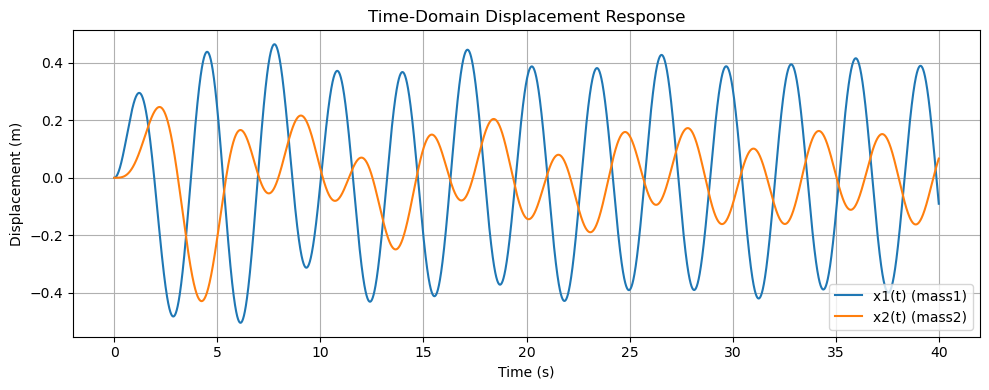

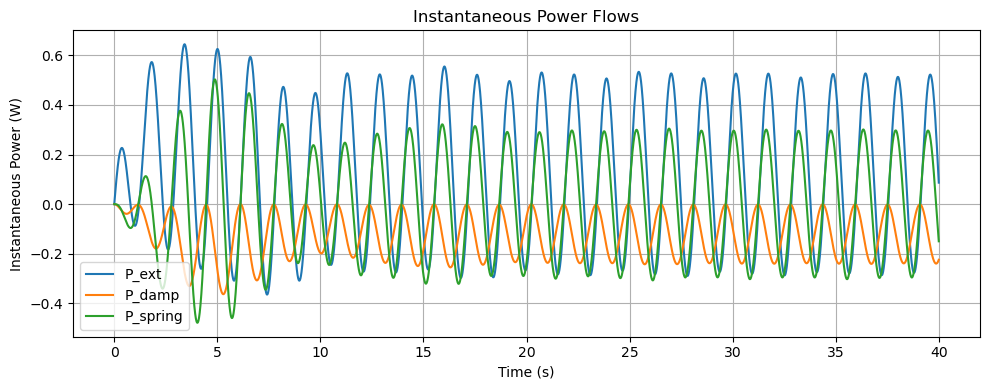

=== Frequency-Domain (Phasor) Results ===
Effective Dynamic Stiffness Kd_eff: (-2.3799126637554586+0.7493449781659389j)
Mass1: Displacement phasor X1: (-0.382284447686653-0.12036699306977919j)  (|X1| = 0.400786 m)
Mass1: Velocity phasor V1:     (0.24073398613955838-0.764568895373306j)
Mass1: Complex Power S:        (0.12036699306977919+0.382284447686653j)
Mass1: Active Power (P):       0.120367 W
Mass1: Reactive Power (Q):     0.382284 var
Mass2: Displacement phasor X2: (0.09750007014393536+0.10409360006733817j)  (|X2| = 0.142624 m)
Mass2: Velocity phasor V2:     (-0.20818720013467634+0.19500014028787072j)

=== Undamped Natural Frequencies (2-DOF) ===
 Mode 1: 0.707107 rad/s
 Mode 2: 1.414214 rad/s

=== Damped Natural Frequencies (2-DOF) ===
 Mode 1: 0.705337 rad/s
 Mode 2: 1.400000 rad/s



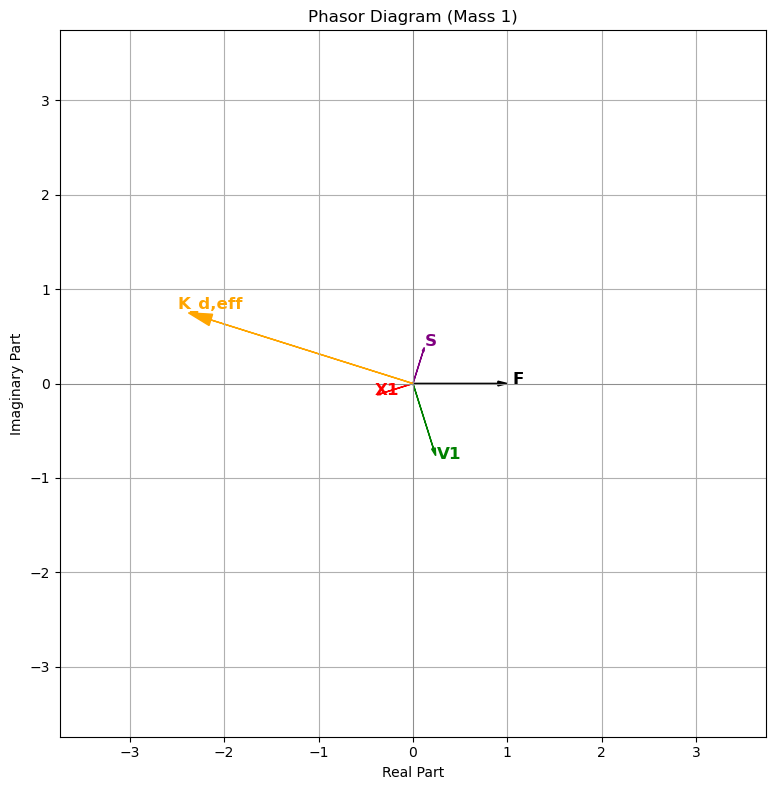

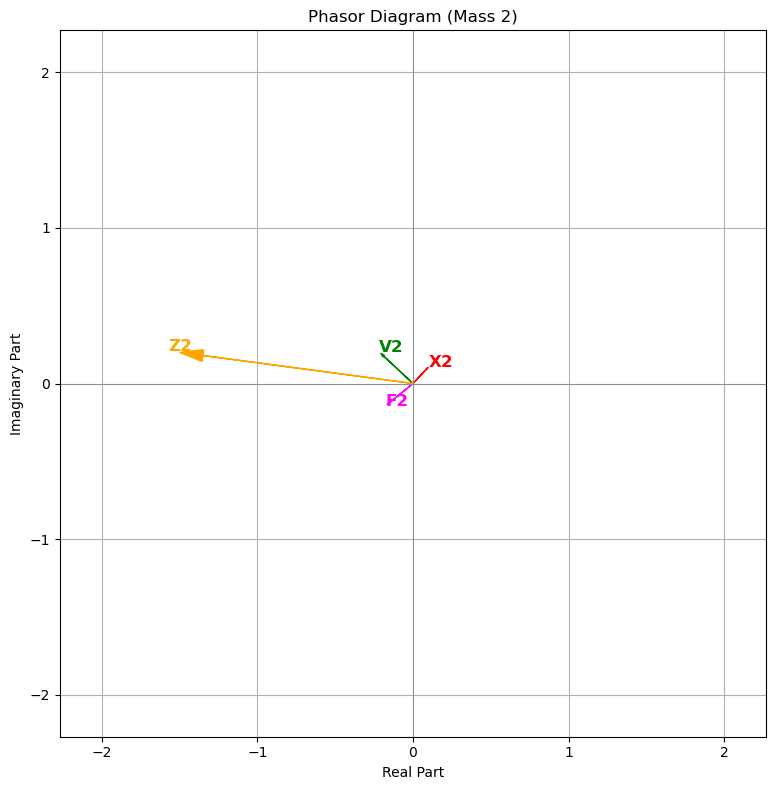

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy.linalg as la

# ==============================
# 1. System Parameters
# ==============================
# Mass1 parameters (attached to ground and driven)
m1 = 1.0       # mass1 (kg)
c1 = 0.2       # damping on mass1 (N·s/m)
k1 = 1.0       # stiffness on mass1 (N/m)

# Mass2 parameters (coupled to mass1)
m2 = 0.5       # mass2 (kg)
c2 = 0.1       # damping between masses (N·s/m)
k2 = 0.5       # stiffness between masses (N/m)

# Driving force (applied to mass1)
F0 = 1.0       # force amplitude (N)
omega = 2.0    # driving angular frequency (rad/s)

# ==============================
# 2. Time-Domain Analysis
# ==============================
def ode_system(z, t):
    # z = [x1, v1, x2, v2]
    x1, v1, x2, v2 = z
    # Equation for mass1:
    a1 = (F0*np.cos(omega*t) - c1*v1 - k1*x1 - c2*(v1 - v2) - k2*(x1 - x2)) / m1
    # Equation for mass2:
    a2 = (- c2*(v2 - v1) - k2*(x2 - x1)) / m2
    return [v1, a1, v2, a2]

t_max = 40.0
num_points = 8001
t = np.linspace(0, t_max, num_points)
z0 = [0.0, 0.0, 0.0, 0.0]
sol = odeint(ode_system, z0, t)
x1 = sol[:, 0]
v1 = sol[:, 1]
x2 = sol[:, 2]
v2 = sol[:, 3]

# Instantaneous power computations:
P_ext = F0 * np.cos(omega*t) * v1  # External power delivered to mass1
P_damp1 = -c1 * v1**2              # Damping power at mass1
P_damp2 = -c2 * (v1 - v2)**2         # Damping power between masses
P_damp = P_damp1 + P_damp2
P_spring1 = -k1 * x1 * v1
P_spring2 = -k2 * (x1 - x2) * (v1 - v2)
P_spring = P_spring1 + P_spring2

# Average power over a steady-state window spanning an integer number of periods:
T = 2*np.pi/omega  # Driving period
N_cycles = 3
t_start = 30.0
t_end = t_start + N_cycles*T
mask = (t >= t_start) & (t <= t_end)
t_steady = t[mask]
P_ext_avg   = np.trapz(P_ext[mask], t_steady) / (t_steady[-1]-t_steady[0])
P_damp_avg  = np.trapz(P_damp[mask], t_steady) / (t_steady[-1]-t_steady[0])
P_spring_avg= np.trapz(P_spring[mask], t_steady) / (t_steady[-1]-t_steady[0])

print("=== Time-Domain Results ===")
print(f"Average External Power  : {P_ext_avg: .6f} W")
print(f"Average Damping Power   : {P_damp_avg: .6f} W")
print(f"Average Spring Power    : {P_spring_avg: .6f} W")
print(f"Net Power (should be ~0): {P_ext_avg+P_damp_avg+P_spring_avg: .3e} W")
print(f"Steady-state |x1| amplitude: {np.max(np.abs(x1[mask])): .6f} m")
print(f"Steady-state |x2| amplitude: {np.max(np.abs(x2[mask])): .6f} m")
print()

# Plot time-domain displacements
plt.figure(figsize=(10,4))
plt.plot(t, x1, label="x1(t) (mass1)")
plt.plot(t, x2, label="x2(t) (mass2)")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.title("Time-Domain Displacement Response")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(t, P_ext, label="P_ext")
plt.plot(t, P_damp, label="P_damp")
plt.plot(t, P_spring, label="P_spring")
plt.xlabel("Time (s)")
plt.ylabel("Instantaneous Power (W)")
plt.title("Instantaneous Power Flows")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 3. Frequency-Domain (Phasor) Analysis
# ==============================
# For the two-mass system, we derive an effective dynamic stiffness for mass1.
Z2 = -m2*omega**2 + k2 + 1j*omega*c2  # Dynamic stiffness for mass2 branch
# From the second equation: X2 = (k2+1j*omega*c2)/Z2 * X1.
# Effective dynamic stiffness seen by mass1:
Kd_eff = (-m1*omega**2 + k1 + k2 + 1j*omega*(c1+c2)) - ((k2+1j*omega*c2)**2)/Z2

X1_phasor = F0 / Kd_eff
V1_phasor = 1j * omega * X1_phasor
S_complex = 0.5 * F0 * np.conjugate(V1_phasor)
P_active = S_complex.real
Q_reactive = S_complex.imag

# For mass2:
X2_phasor = (k2+1j*omega*c2)/Z2 * X1_phasor
V2_phasor = 1j * omega * X2_phasor
F2_phasor = Z2 * X2_phasor  # Force in the mass2 branch

print("=== Frequency-Domain (Phasor) Results ===")
print(f"Effective Dynamic Stiffness Kd_eff: {Kd_eff}")
print(f"Mass1: Displacement phasor X1: {X1_phasor}  (|X1| = {np.abs(X1_phasor):.6f} m)")
print(f"Mass1: Velocity phasor V1:     {V1_phasor}")
print(f"Mass1: Complex Power S:        {S_complex}")
print(f"Mass1: Active Power (P):       {P_active:.6f} W")
print(f"Mass1: Reactive Power (Q):     {Q_reactive:.6f} var")
print(f"Mass2: Displacement phasor X2: {X2_phasor}  (|X2| = {np.abs(X2_phasor):.6f} m)")
print(f"Mass2: Velocity phasor V2:     {V2_phasor}")
print()

# ==============================
# 4. Natural Frequencies Calculation
# ==============================
# 4a. Undamped Natural Frequencies (Free Vibration, 2-DOF)
M = np.array([[m1, 0],
              [0, m2]])
K = np.array([[k1+k2, -k2],
              [-k2,    k2]])
eigvals, _ = la.eig(la.inv(M).dot(K))
# We expect positive eigenvalues (ω^2). Take positive square roots.
omega_n_undamped = np.sort(np.sqrt(np.real(eigvals)))
print("=== Undamped Natural Frequencies (2-DOF) ===")
for i, w in enumerate(omega_n_undamped, 1):
    print(f" Mode {i}: {w:.6f} rad/s")
print()

# 4b. Damped Natural Frequencies from the Full System (Eigenvalue Analysis)
# Build the state-space matrix A for the full (damped) 2-DOF system.
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [-(k1+k2)/m1, k2/m1, -(c1+c2)/m1, c2/m1],
    [k2/m2, -k2/m2, c2/m2, -c2/m2]
])
eigvals_A, _ = la.eig(A)
# Select eigenvalues with nonzero imaginary parts (positive ones) for the oscillatory modes.
damped_freqs = sorted([np.abs(np.imag(ev)) for ev in eigvals_A if np.imag(ev) > 0])
print("=== Damped Natural Frequencies (2-DOF) ===")
for i, wd in enumerate(damped_freqs, 1):
    print(f" Mode {i}: {wd:.6f} rad/s")
print()

# ==============================
# 5. Visualization: Phasor Diagrams
# ==============================
def draw_arrow(z, label, color):
    plt.arrow(0, 0, z.real, z.imag,
              head_width=0.05*np.abs(z),
              head_length=0.1*np.abs(z),
              fc=color, ec=color, length_includes_head=True)
    plt.text(z.real*1.05, z.imag*1.05, label, color=color,
             fontsize=12, fontweight='bold')

# 5a. Phasor Diagram for Mass1
plt.figure(figsize=(8,8))
F1_phasor = F0 + 0j  # External force applied to mass1 (assumed real)
draw_arrow(F1_phasor, "F", "black")
draw_arrow(X1_phasor, "X1", "red")
draw_arrow(V1_phasor, "V1", "green")
draw_arrow(S_complex, "S", "purple")
draw_arrow(Kd_eff, "K_d,eff", "orange")
phasors1 = [F1_phasor, X1_phasor, V1_phasor, S_complex, Kd_eff]
max_val1 = max(np.abs(z) for z in phasors1) * 1.5
plt.xlim(-max_val1, max_val1)
plt.ylim(-max_val1, max_val1)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Phasor Diagram (Mass 1)")
plt.grid(True)
plt.axhline(0, color="grey", lw=0.5)
plt.axvline(0, color="grey", lw=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

# 5b. Phasor Diagram for Mass2
plt.figure(figsize=(8,8))
draw_arrow(X2_phasor, "X2", "red")
draw_arrow(V2_phasor, "V2", "green")
draw_arrow(F2_phasor, "F2", "magenta")
draw_arrow(Z2, "Z2", "orange")
phasors2 = [X2_phasor, V2_phasor, F2_phasor, Z2]
max_val2 = max(np.abs(z) for z in phasors2) * 1.5
plt.xlim(-max_val2, max_val2)
plt.ylim(-max_val2, max_val2)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Phasor Diagram (Mass 2)")
plt.grid(True)
plt.axhline(0, color="grey", lw=0.5)
plt.axvline(0, color="grey", lw=0.5)
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

# ==============================
# 6. Discussion and Workflow Summary
# ==============================
#
# This integrated script provides a unified workflow for analyzing a two-mass system:
#
# 1. In the time domain, it shows the transient and steady-state displacement responses and
#    computes instantaneous and averaged power flows.
#
# 2. In the frequency domain, it uses an effective dynamic stiffness to compute phasor quantities
#    (displacements, velocities, and complex power), along with phasor diagrams for both masses.
#
# 3. The script computes undamped natural frequencies (from the eigenvalue problem of K and M)
#    and damped natural frequencies (from the state-space eigenvalues of the full system).
#
# By comparing the outputs from both analyses, you can:
#   - Verify that the energy balance (input vs. dissipated power) is maintained.
#   - Assess whether the system is overdriven or underdriven.
#   - Identify potential resonance issues and how damping affects the oscillatory modes.
#
# This workflow and these calculations can then guide you to improve your system design by
# adjusting masses, stiffnesses, or damping to achieve the desired performance.
